In [44]:
import pandas as pd
import numpy as np
import warnings

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report 
from sklearn.model_selection import train_test_split, cross_val_score

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Load in Data

In [3]:
df = pd.read_csv("dataset.csv")

# Data Cleaning/Extraction

In [4]:
df.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


In [5]:
df.shape

(35717, 4)

In [6]:
df.describe()

,Capacity,Occupancy
count,35717.000000,35717.000000
mean,1397.550130,642.228911
std,1179.326833,656.955535
min,220.000000,-8.000000
25%,500.000000,210.000000
50%,849.000000,446.000000
75%,2009.000000,798.000000
max,4675.000000,4327.000000


Negative occupancy. Let's check that out

In [7]:
df[df['Occupancy'] < 0].shape

(12, 4)

In [8]:
df[df['Occupancy'] < 0]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
23889,NIA North,480,-3,2016-10-16 15:57:16
23890,NIA North,480,-3,2016-10-16 16:31:17
23906,NIA North,480,-1,2016-10-18 15:27:59
23919,NIA North,480,-8,2016-10-28 13:02:43
23924,NIA North,480,-1,2016-10-28 15:29:41
23925,NIA North,480,-4,2016-10-28 16:02:40
23926,NIA North,480,-1,2016-10-28 16:29:42
23937,NIA North,480,-2,2016-10-29 12:59:51
23944,NIA North,480,-1,2016-10-29 16:26:53
23997,NIA North,480,-3,2016-11-10 16:00:15


All from NIA North. 

In [9]:
df['SystemCodeNumber'].value_counts()

BHMMBMMBX01         1312
Others-CCCPS202     1312
Shopping            1312
Others-CCCPS119a    1312
BHMBCCTHL01         1312
BHMNCPNST01         1312
BHMBCCMKT01         1312
Others-CCCPS8       1312
Others-CCCPS98      1312
Broad Street        1312
Others-CCCPS135a    1312
BHMEURBRD01         1312
Others-CCCPS105a    1312
BHMNCPHST01         1312
BHMBCCSNH01         1294
Others-CCCPS133     1294
BHMNCPLDH01         1292
BHMNCPPLS01         1291
BHMEURBRD02         1276
BHMBCCPST01         1276
NIA South           1204
NIA Car Parks       1204
BHMBRCBRG02         1186
BHMBRCBRG03         1186
Bull Ring           1186
BHMBRCBRG01         1186
BHMNCPRAN01         1186
BHMNCPNHS01         1038
NIA North            162
BHMBRTARC01           88
Name: SystemCodeNumber, dtype: int64

Out of 162 NIA North values, we have 12 values that have negative occupancy. Let's change those to 0. 

In [10]:
df.loc[df['Occupancy'] < 0, 'Occupancy'] = 0
df[df['Occupancy'] < 0]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated


So now we have no negative values. 

Let's calculate OccupancyRate, and convert LastUpdated to datetime

In [11]:
df['OccupancyRate'] = round(df['Occupancy'] * 100/ df['Capacity'], 2)
df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00


In [12]:
df_duplicated = df[df.duplicated()]
df_duplicated.shape

(216, 5)

We have some duplicated values. Let's remove those.

In [13]:
df = df.drop_duplicates()
df.shape

(35501, 5)

In [14]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df.tail(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate
35496,Shopping,1920,1517,2016-12-19 14:30:33,79.01
35497,Shopping,1920,1487,2016-12-19 15:03:34,77.45
35498,Shopping,1920,1432,2016-12-19 15:29:33,74.58
35499,Shopping,1920,1321,2016-12-19 16:03:35,68.80
35500,Shopping,1920,1180,2016-12-19 16:30:35,61.46


Let's check if there are any null values

In [15]:
df.isna().any()

SystemCodeNumber    False
Capacity            False
Occupancy           False
LastUpdated         False
OccupancyRate       False
dtype: bool

Now let's analyze LastUpdated and see if there are any unique values. 

In [16]:
df_lastupdated_value_counts = pd.DataFrame(df['LastUpdated'].value_counts())
df_lastupdated_value_counts

,LastUpdated
2016-11-20 12:01:20,29
2016-11-10 14:27:13,29
2016-10-28 14:02:39,29
2016-11-30 15:01:39,29
2016-11-07 15:33:53,29
2016-10-28 13:29:45,29
2016-10-18 13:28:57,29
2016-10-18 12:27:57,29
2016-11-07 16:33:53,29
2016-11-10 09:27:11,29


We have dates listed once. Should we remove them? 

In [17]:
df_lastupdated_value_counts['LastUpdated'].value_counts()

28    500
1     401
27    264
26    175
29    107
24     97
23     55
25     55
2      45
22     33
3      20
21     10
20      8
4       8
6       3
19      2
17      1
Name: LastUpdated, dtype: int64

There's 401 dates that are listed once. That's a lot of data that we'd discard. This also implies that our time series doesn't follow a consistent interval (updates every hour, every day, every minute, etc). 

To better represent this data, we need to split LastUpdated into Year, Month, Day, Hour, Minutes, and Seconds. Although based on these value counts, minutes and seconds may not add much value to our analysis. 

Perhaps it would be better if we split this up into Year, Month, Date. And have time intervals to convey morning rush and afternoon rush.

Let's split up the date time from LastUpdated

In [18]:
df['Year'] = df['LastUpdated'].dt.year
df['Month'] = df['LastUpdated'].dt.month
df['Day'] = df['LastUpdated'].dt.day
df['Hours'] = df['LastUpdated'].dt.hour
df['Minutes'] = df['LastUpdated'].dt.minute
df['Seconds'] = df['LastUpdated'].dt.second
df['Day of the Week'] = df['LastUpdated'].dt.weekday
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,Seconds,Day of the Week
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,42,1
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,42,1
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,42,1
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,46,1
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,48,1


In [19]:
df['Hours'].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

There are 10 unique hours. Let's split into Morning, Noon, and Afternoon.
* Morning: 7 - 10
* Noon: 10 - 13
* Afternoon: 13-16

In [20]:
df['Morning_Hours'] = df.apply(lambda row: 1 if row['Hours'] < 10 else 0, axis=1)
df['Noon_Hours'] = df.apply(lambda row: 1 if row['Hours'] >= 10 and row['Hours'] < 13 else 0, axis=1)
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,Seconds,Day of the Week,Morning_Hours,Noon_Hours
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,42,1,1,0
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,42,1,1,0
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,42,1,1,0
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,46,1,1,0
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,48,1,1,0


In [21]:
df['Morning_Hours'].value_counts()

0    26828
1     8673
Name: Morning_Hours, dtype: int64

In [22]:
df['Noon_Hours'].value_counts()

0    23836
1    11665
Name: Noon_Hours, dtype: int64

Day of the week is a categorical variable, but is treated as an ordinal. We need to break up day of the Week so that we can accurately represent this in categorical format.

In [23]:
df['Monday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 0 else 0, axis=1)
df['Tuesday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 1 else 0, axis=1)
df['Wednesday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 2 else 0, axis=1)
df['Thursday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 3 else 0, axis=1)
df['Friday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 4 else 0, axis=1)
df['Saturday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 5 else 0, axis=1)
df['Sunday'] = df.apply(lambda row: 1 if row['Day of the Week'] == 6 else 0, axis=1)
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Day of the Week,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,...,1,1,0,0,1,0,0,0,0,0
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,...,1,1,0,0,1,0,0,0,0,0
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,...,1,1,0,0,1,0,0,0,0,0
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,...,1,1,0,0,1,0,0,0,0,0
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,...,1,1,0,0,1,0,0,0,0,0


# Exploratory Data Analysis

In [26]:
def get_daily_system_code_df(df_system_code): 
    df_system_code_daily = df_system_code[['OccupancyRate', 'Year', 'Month', 'Day']]
    df_system_code_daily = df_system_code_daily.groupby(['Year', 'Month', 'Day']).agg('mean')
    df_system_code_daily = df_system_code_daily.reset_index()
    df_system_code_daily['Date'] = pd.to_datetime(df_system_code_daily[['Year', 'Month', 'Day']], format='%d%b%Y')
    return df_system_code_daily

In [28]:
def get_system_code_df(df_system_code, time):
    df_system_code = df_system_code[['OccupancyRate', time]]
    df_system_code = df_system_code.groupby([time]).agg('mean')
    df_system_code = df_system_code.reset_index()
    return df_system_code

Let's work with one System Code Number: BHMBCCMKT01

## System Code Number: BHMBCCMKT01

In [24]:
df_BHMBCCMKT01 = df[df['SystemCodeNumber'] == 'BHMBCCMKT01']
df_BHMBCCMKT01.shape

(1307, 21)

In [25]:
df_BHMBCCMKT01['Capacity'].value_counts()

577    1307
Name: Capacity, dtype: int64

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



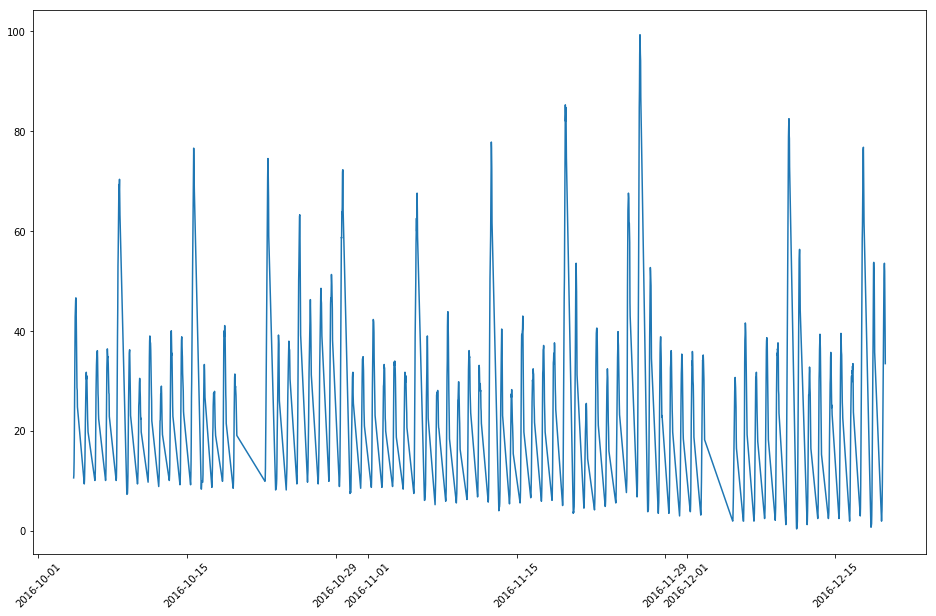

In [29]:
plt.figure(figsize=(16,10))
plt.xticks(rotation=45)
plt.plot(df_BHMBCCMKT01['LastUpdated'], df_BHMBCCMKT01['OccupancyRate'])

There seems to be some sort of trend going on, but it's hard to tell. Let's see how it is by year, month, and day.

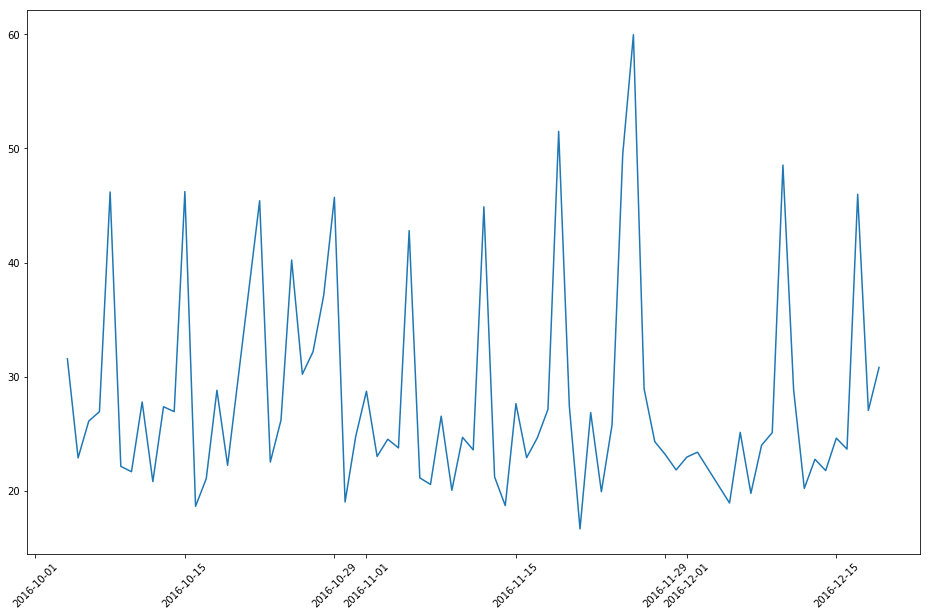

In [31]:
plt.figure(figsize=(16,10))
df_BHMBCCMKT01_daily = get_daily_system_code_df(df_BHMBCCMKT01)
plt.xticks(rotation=45)
plt.plot(df_BHMBCCMKT01_daily['Date'], df_BHMBCCMKT01_daily['OccupancyRate'])

There seems to be the highest occupancy in November. Assumption is Thanksgiving/Holidays and folks want to spend time with families outside. 

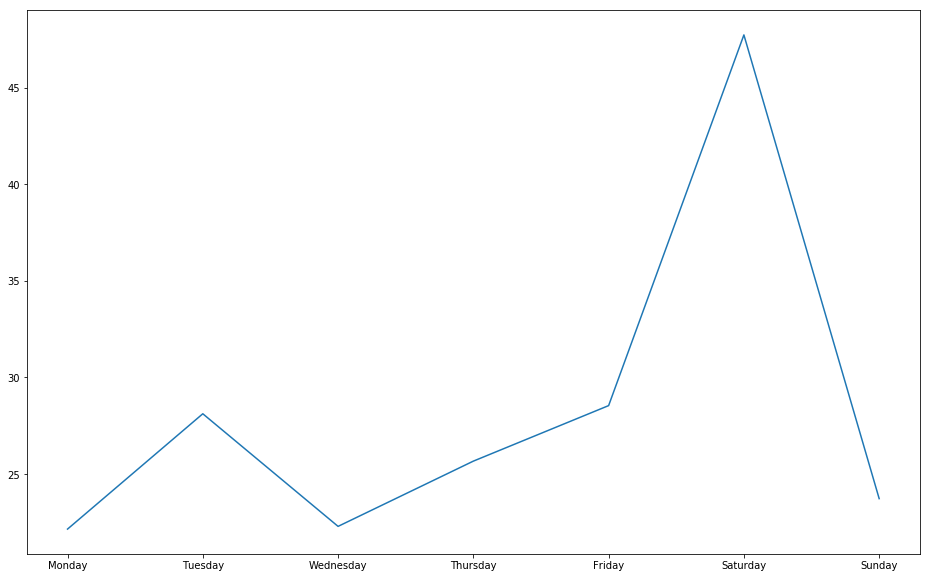

In [32]:
plt.figure(figsize=(16,10))
df_BHMBCCMKT01_dow = get_system_code_df(df_BHMBCCMKT01, 'Day of the Week')
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.plot(df_BHMBCCMKT01_dow['Day of the Week'], df_BHMBCCMKT01_dow['OccupancyRate'])

Saturday seems to be at the highest peak.

Let's plot multiple systemcodes and see if the trend is similar

## Multiple System Codes

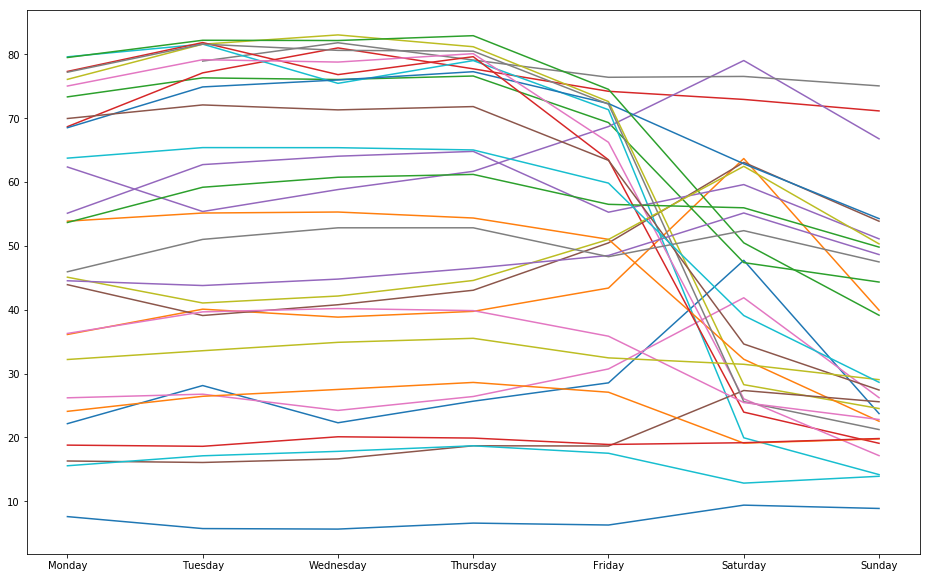

In [33]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Day of the Week')
    plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
    plt.plot(df_dow['Day of the Week'], df_dow['OccupancyRate'], label=system_code)

So some parking lots peak on Saturdays while others do not. This may be interesting to include in clustering analysis.

In [34]:
df['Hours'].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

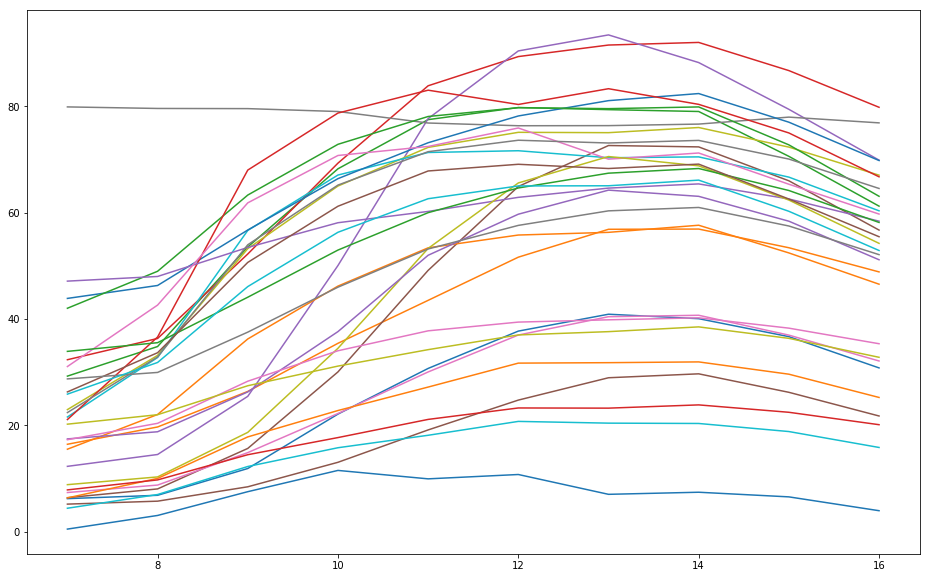

In [35]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Hours')
    plt.plot(df_dow['Hours'], df_dow['OccupancyRate'], label=system_code)

Some occupancy rates peak between hours 12-14. Others do not. May be useful for clustering analysis.

In [36]:
df['Day'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3, 20, 21])

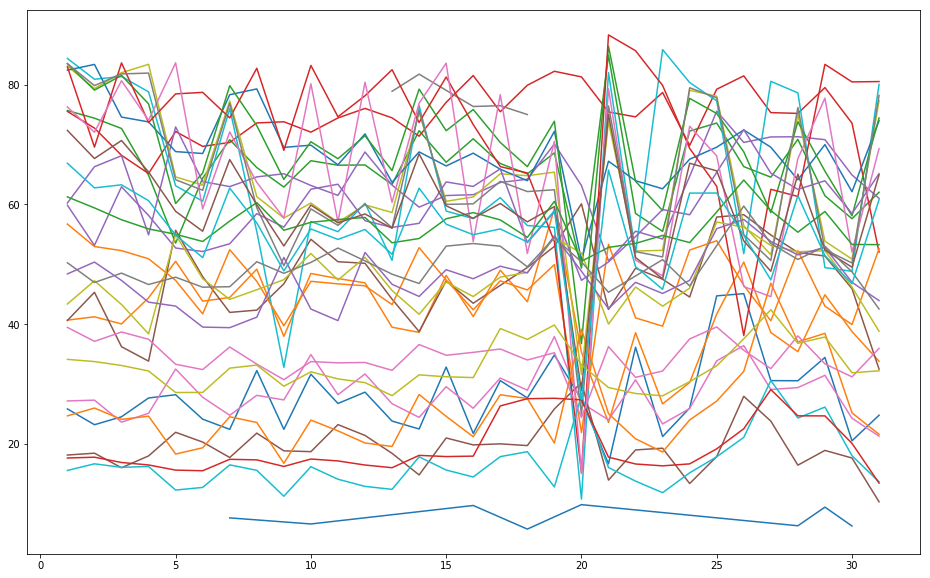

In [37]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Day')
    plt.plot(df_dow['Day'], df_dow['OccupancyRate'], label=system_code)

In [38]:
df['Month'].unique()

array([10, 11, 12])

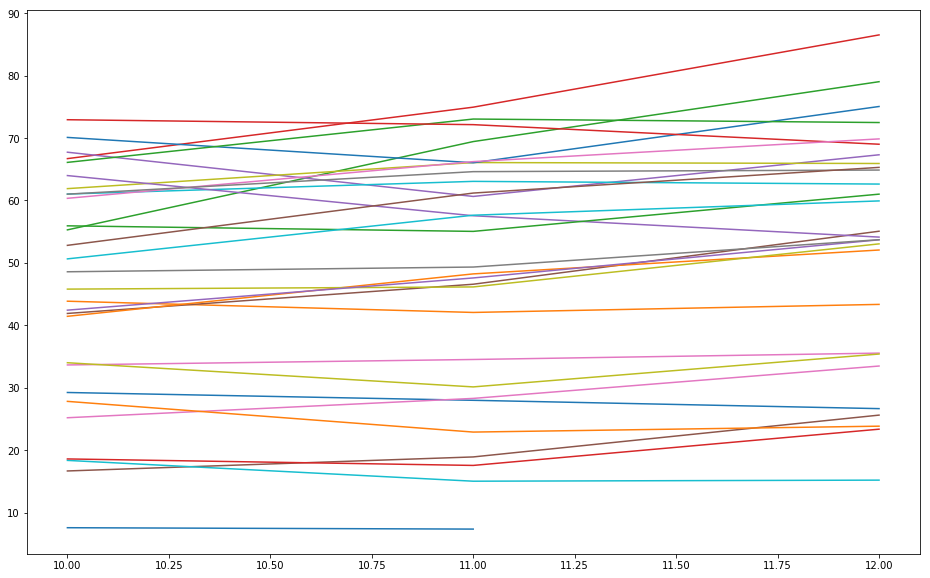

In [39]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Month')
    plt.plot(df_dow['Month'], df_dow['OccupancyRate'], label=system_code)

Day and Month may not be good predictors for clustering analysis, as each line is a different trend and there are some missing values.

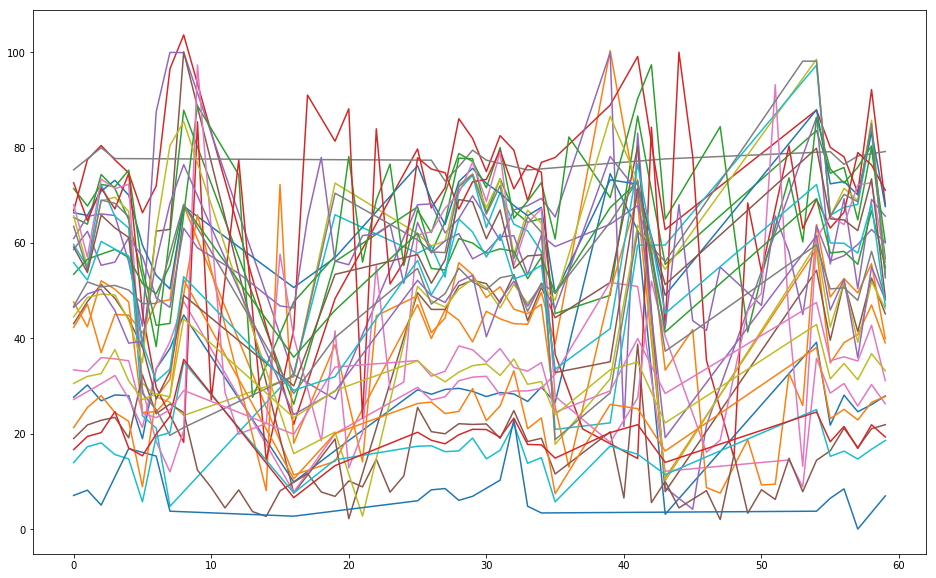

In [42]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Minutes')
    plt.plot(df_dow['Minutes'], df_dow['OccupancyRate'], label=system_code)

Minutes may be useful for clustering analysis. There are certain peaks which are consistent (around 8, 20, 42 to name a few).

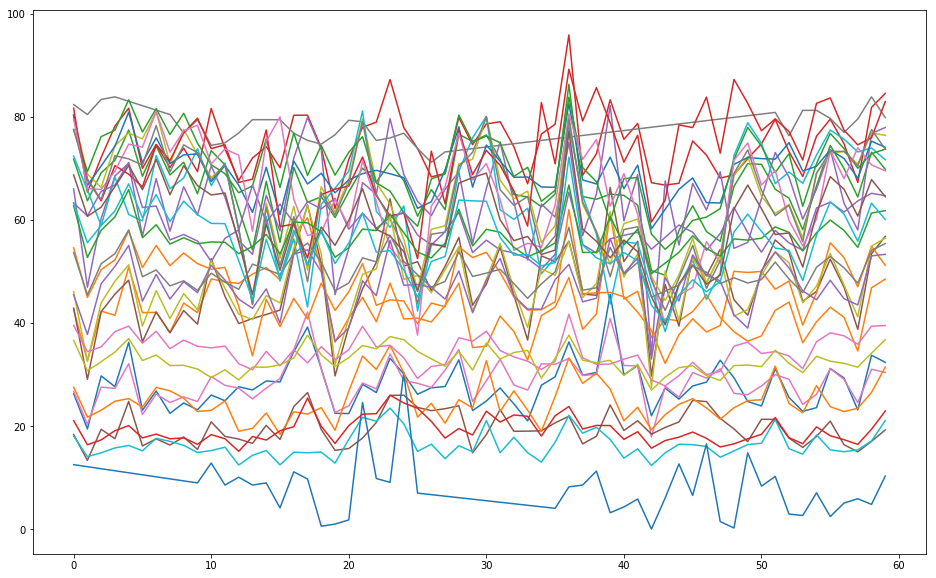

In [43]:
plt.figure(figsize=(16,10))
for system_code in df['SystemCodeNumber'].unique():
    df_dow = get_system_code_df(df[df['SystemCodeNumber'] == system_code], 'Seconds')
    plt.plot(df_dow['Seconds'], df_dow['OccupancyRate'], label=system_code)

Seonds may be useful for clustering analysis. There are certain peaks which are consistent (around 27, 37).

# Clustering

In [46]:
df.tail(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Day of the Week,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
35496,Shopping,1920,1517,2016-12-19 14:30:33,79.01,2016,12,19,14,30,...,0,0,0,1,0,0,0,0,0,0
35497,Shopping,1920,1487,2016-12-19 15:03:34,77.45,2016,12,19,15,3,...,0,0,0,1,0,0,0,0,0,0
35498,Shopping,1920,1432,2016-12-19 15:29:33,74.58,2016,12,19,15,29,...,0,0,0,1,0,0,0,0,0,0
35499,Shopping,1920,1321,2016-12-19 16:03:35,68.80,2016,12,19,16,3,...,0,0,0,1,0,0,0,0,0,0
35500,Shopping,1920,1180,2016-12-19 16:30:35,61.46,2016,12,19,16,30,...,0,0,0,1,0,0,0,0,0,0


So capacity and occupancy rate are what we need to cluster on. We also need a time component to account for the varying occupancy rates in a common capacity. We won't do day and month based on EDA. After playing around with clustering and seeing what works, Hours and Minutes added more value to our clusters than everything else. 

In [45]:
df.shape

(35501, 21)

In [46]:
X = df[['Capacity', 'OccupancyRate', 'Hours', 'Minutes']]
X.head(5)

,Capacity,OccupancyRate,Hours,Minutes
0,577,10.57,7,59
1,577,11.09,8,25
2,577,13.86,8,59
3,577,18.54,9,32
4,577,26.00,9,59


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



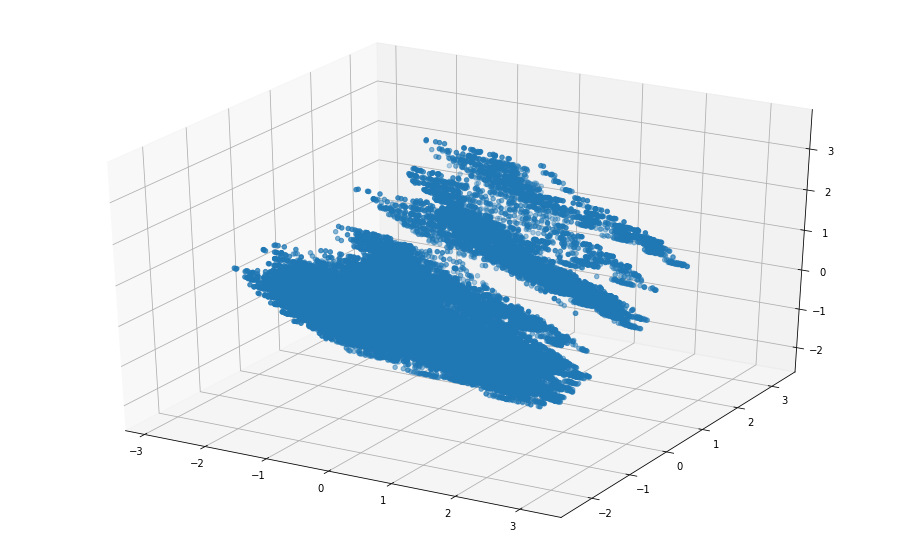

In [47]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)
pca_components_df = pd.DataFrame(pca_components)
ax.scatter(pca_components_df[0], pca_components_df[1], pca_components_df[2])

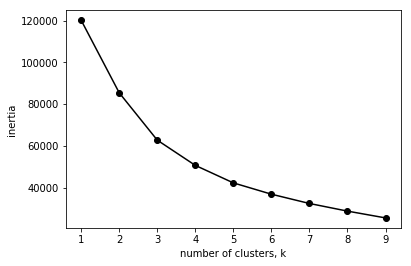

In [50]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(init='k-means++', n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_components_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Intertia looks good at 3, so let's make k = 3.

In [51]:
n_clusters=3

I'm using Hierarchical Agglomerative Clustering with linkage ward. While this is computationally slow, I chose this for the following reasons
* Reproducible results (K means differs every iteration)
* Results are more intuitive than K-means. K-means works well if data is in sphere-like results, which isn't the case here. 

I chose ward linkage because I didn't want to merge on distance. I wanted to merge on the combination that gives the lowest inertia.


In [52]:
pca_components_df.shape

(35501, 3)

In [53]:
Agglomerative_model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
Agglomerative_model.fit(pca_components_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [54]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster_3d(X,m=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111, projection='3d')
    if num_clusters == 0:
        ax.scatter(X[:,0],X[:,1],X[:,2],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            ax.scatter(X[m.labels_==i,0],X[m.labels_==i,1],X[m.labels_==i,2],c = color[i],alpha = alpha,s=s,label=i)
    ax.legend()

In [55]:
cluster_labels = pd.DataFrame(Agglomerative_model.labels_, columns=["Cluster"])
cluster_labels.shape

(35501, 1)

In [56]:
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Day of the Week,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,...,1,1,0,0,1,0,0,0,0,0
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,...,1,1,0,0,1,0,0,0,0,0
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,...,1,1,0,0,1,0,0,0,0,0
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,...,1,1,0,0,1,0,0,0,0,0
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,...,1,1,0,0,1,0,0,0,0,0


In [57]:
df = df.join(cluster_labels)
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cluster
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,...,1,0,0,1,0,0,0,0,0,1
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,...,1,0,0,1,0,0,0,0,0,1
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,...,1,0,0,1,0,0,0,0,0,1
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,...,1,0,0,1,0,0,0,0,0,1
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,...,1,0,0,1,0,0,0,0,0,1


In [58]:
df[['Capacity', 'Occupancy', 'OccupancyRate', 'Month', 'Day', 'Hours', 'Minutes', 'Seconds', 'Morning_Hours', 'Noon_Hours', 'Day of the Week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Cluster']].groupby(['Cluster']).mean()

,Capacity,Occupancy,OccupancyRate,Month,Day,Hours,Minutes,Seconds,Morning_Hours,Noon_Hours,Day of the Week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Cluster,,,,,,,,,,,,,,,,,,
0,840.136876,553.586947,67.825565,10.901823,14.963541,13.296211,28.760032,29.296895,0.031730,0.301499,2.683693,0.157531,0.166988,0.167610,0.155167,0.144777,0.110683,0.097244
1,844.727218,260.893530,30.674945,10.850908,15.312079,9.780752,22.485466,28.326400,0.535248,0.365868,3.135538,0.143296,0.136306,0.136391,0.121217,0.128719,0.156508,0.177564
2,3411.913343,1420.635572,39.996383,10.893335,15.116799,11.813304,25.891906,28.867611,0.244771,0.328310,2.904378,0.152007,0.151098,0.151228,0.137976,0.135637,0.137976,0.134078


Some key takeaways
* Cluster 2 stands out the most with an extremly high capacity, but a medium-low occupancy rate.
* Clusters 1 and 0 are very similar in capacity, but have different occupancy rates. Cluster 0 has a medium-high occpuancy rate whereas Cluster 1 has a medium-low occupancy rate. 
* The time components are very similar for all 3 clusters, indicating that time isn't important in clustering analysis. Month, Day , Hours, Minutes, Seconds, Day of the Week are all very similar. Even the generated features Morning_Hours, Noon_Hours, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday are very similar among all three clusters. 

What does this visually look like?

<Figure size 1440x864 with 0 Axes>

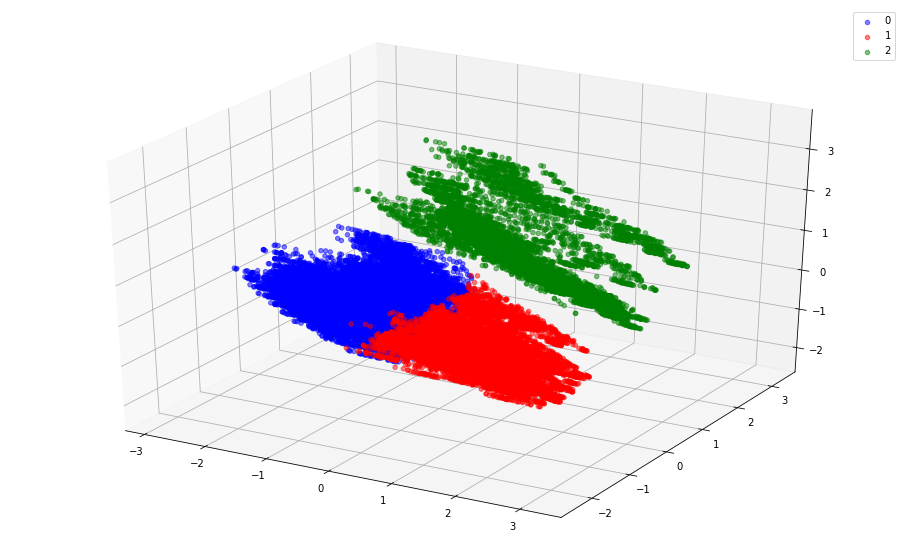

In [59]:
plt.figure(figsize=(20,12))
display_cluster_3d(pca_components,Agglomerative_model,n_clusters)

There isn't much separability between Clusters 0 and 1, except for different occupancy rates. Cluster 2 is highly separable due to its high capacity. 

These 3 clusters could be explained by the following
* Cluster 0: Parking lots with low capacity but high occupancy rates on average
* Cluster 1: Parking lots with low capacity but low occupancy rates on average
* Cluster 2: Parking lots with high capacity but low occupancy rates on average

If we were to formulate a business scenario, we could look at parking lots that fall in Clusters 1 and 2. See why they have a low occupancy rate, and what can we do to increase it. Lot of factors can influence this (price of parking lot, location), but we don't have such data to analyze this. All we have are time stamps, which we will use for our classification analysis. 

In [60]:
df.shape

(35501, 22)

In [61]:
df[df.isna().any(axis=1)]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cluster


In [63]:
with open('df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# Classification

In [8]:
with open('df.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [9]:
df.head(5)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,Year,Month,Day,Hours,Minutes,...,Morning_Hours,Noon_Hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Cluster
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,10.57,2016,10,4,7,59,...,1,0,0,1,0,0,0,0,0,1
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,11.09,2016,10,4,8,25,...,1,0,0,1,0,0,0,0,0,1
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,13.86,2016,10,4,8,59,...,1,0,0,1,0,0,0,0,0,1
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,18.54,2016,10,4,9,32,...,1,0,0,1,0,0,0,0,0,1
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,26.00,2016,10,4,9,59,...,1,0,0,1,0,0,0,0,0,1


## Feature Selection

In [10]:
df.columns

Index(['SystemCodeNumber', 'Capacity', 'Occupancy', 'LastUpdated',
       'OccupancyRate', 'Year', 'Month', 'Day', 'Hours', 'Minutes', 'Seconds',
       'Day of the Week', 'Morning_Hours', 'Noon_Hours', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Cluster'],
      dtype='object')

So using the data given, we want to create a classification model that predicts which cluster a parking lot will fall under based on capacity, occupancyrate, month, day, hours, minutes, seconds, day of the week, morning_hours, noon_hours, etc. We can't use all the features, so we'll have to select which ones are relevant. We'll use a correlation matrix to solve for this.

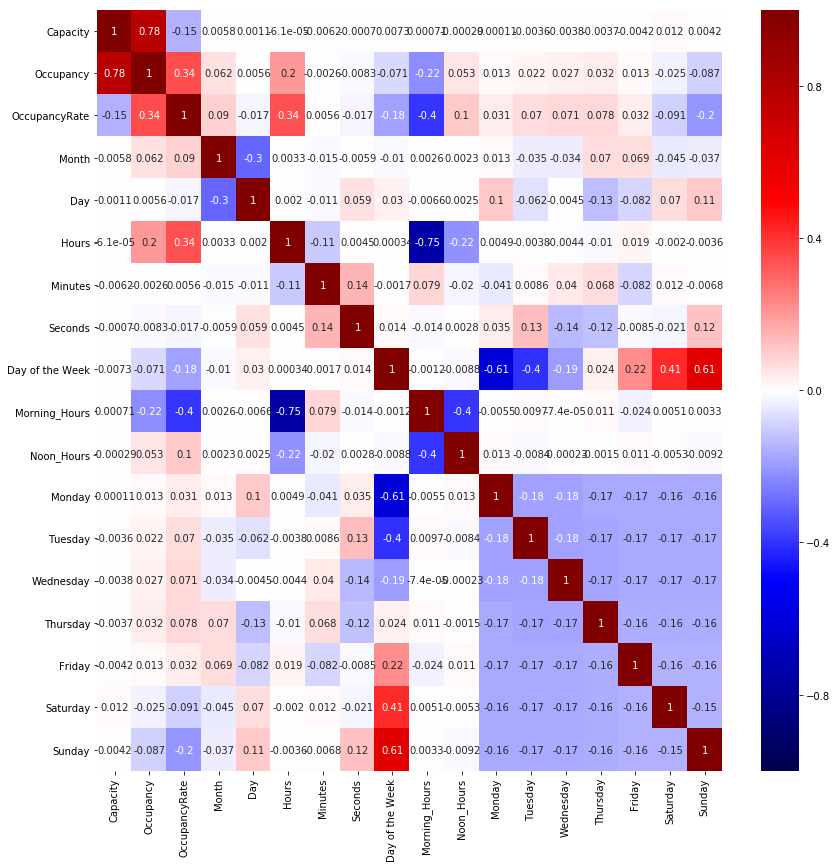

In [11]:
plt.figure(figsize=(14,14))
sns.heatmap(df[['Capacity', 'Occupancy',
       'OccupancyRate', 'Month', 'Day', 'Hours', 'Minutes', 'Seconds',
       'Day of the Week', 'Morning_Hours', 'Noon_Hours', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].corr(), 
            cmap="seismic", annot=True, vmin=-1, vmax=1);

Features to remove
* Occupancy - highly correlated with Capacity
* Morning_Hours - highly correlated with Hours
* Noon_Hours - redundant if we're using hours
* Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday - redundant if we're already using Day of the Week

So our list of features includes 
* Capacity
* OccupancyRate
* Month
* Day
* Hours
* Minutes
* Seconds
* Day of the Week

In [12]:
df.shape

(35501, 22)

So we have a lot of data points, and we're using 8 features. Furthermore, we're predicting a multiclass variable (Cluster). Algorithms to try out are Multinomial Logistic Regression, Decision Tree, Random Forest, and Naive Bayes. 

In [13]:
df['Cluster'].value_counts()

0    16073
1    11731
2     7697
Name: Cluster, dtype: int64

## Train/Test Split

In [14]:
X = df[['Capacity', 'OccupancyRate', 'Month', 'Day', 'Hours', 'Minutes', 'Seconds', 'Day of the Week']]
y = df[['Cluster']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [16]:
models = {
    "Logistic": [ LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 4444), X_train, X_test] ,
    "NB": [ GaussianNB(), X_train, X_test] ,
    "Decision Tree": [ DecisionTreeClassifier(random_state=4444), X_train, X_test] ,
    "Random Forest": [ RandomForestClassifier(random_state=4444), X_train, X_test]
}

for key in models.keys():
    model_fit = models[key][0].fit(models[key][1], y_train)
    model_accuracy = accuracy_score(y_train, models[key][0].predict(models[key][1]))
    model_precision = precision_score(y_train, models[key][0].predict(models[key][1]), average='weighted')
    model_recall = recall_score(y_train, models[key][0].predict(models[key][1]), average='weighted')
    model_f1 = f1_score(y_train, models[key][0].predict(models[key][1]), average='weighted')        
    model_log_loss = log_loss(y_train, models[key][0].predict_proba(models[key][1]))
    print("\n\nTrain Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 
    
    
    model_fit = models[key][0].fit(models[key][1], y_train)
    model_accuracy = accuracy_score(y_test, models[key][0].predict(models[key][2]))
    model_precision = precision_score(y_test, models[key][0].predict(models[key][2]), average='weighted')
    model_recall = recall_score(y_test, models[key][0].predict(models[key][2]), average='weighted')
    model_f1 = f1_score(y_test, models[key][0].predict(models[key][2]), average='weighted')        
    model_log_loss = log_loss(y_test, models[key][0].predict_proba(models[key][2]))
    print("\n\nTest Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().





Train Model: Logistic
Accuracy: 0.9118712273641851
Precision: 0.9114924729951556
Recall: 0.9118712273641851
F1: 0.9116072062723817
Log-Loss: 0.20550187995722058


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected.



Test Model: Logistic
Accuracy: 0.9078020843113322
Precision: 0.9074573706191297
Recall: 0.9078020843113322
F1: 0.9075991622904498
Log-Loss: 0.2136157908909928


Train Model: NB
Accuracy: 0.933400402414487
Precision: 0.9338006916508297
Recall: 0.933400402414487
F1: 0.9328797560411671
Log-Loss: 0.15962235017291668


Test Model: NB
Accuracy: 0.934372359402873
Precision: 0.9349908755651972
Recall: 0.934372359402873
F1: 0.9338324076337432
Log-Loss: 0.15875133823613602


Train Model: Decision Tree
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Log-Loss: 2.1094237467877998e-15


Test Model: Decision Tree
Accuracy: 0.9892967796451038
Precision: 0.9892960297981052
Recall: 0.9892967796451038
F1: 0.9892963591852003
Log-Loss: 0.3696761345432203


Train Model: Random Forest
Accuracy: 0.999195171026157
Precision: 0.9991960440649738
Recall: 0.999195171026157
F1: 0.9991950655275517
Log-Loss: 0.01882282801198901


/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().





Test Model: Random Forest
Accuracy: 0.9838512815698056
Precision: 0.9838892194754901
Recall: 0.9838512815698056
F1: 0.9838320680029763
Log-Loss: 0.07840996143456187


Train and Test accuracies are insanely high for all of my models. Decision Tree has a training accuracy of 100% , which I think is a cause of overfitting. I'm going to go with Random Forest just because it has a high train and test accuracy, and I'm safe from overfitting. In addition, Random Forest has the lowest log-loss for its test model out of all other algorithms.  

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.9838512815698056
0.9838892194754901
0.9838512815698056
0.9838320680029763


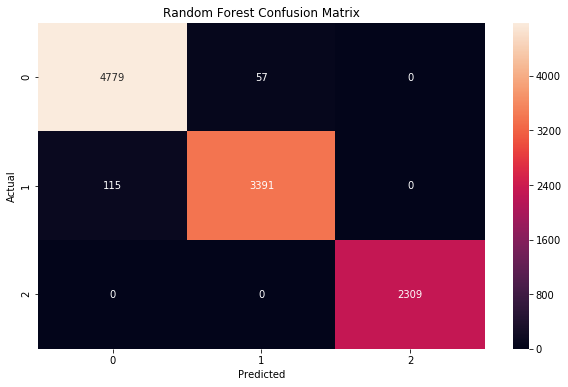

In [17]:
rf = RandomForestClassifier(random_state=4444)
rf.fit(X_train, y_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), 
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')

print(accuracy_score(y_test, rf.predict(X_test)))
print(precision_score(y_test, rf.predict(X_test), average='weighted'))
print(recall_score(y_test, rf.predict(X_test), average='weighted'))
print(f1_score(y_test, rf.predict(X_test), average='weighted'))

So random forest predicts Cluster 2 with 100% accuracy. Which makes sense because as we saw in clustering analysis, Cluster 2 was easily separable from Cluster 1 and 0. Random forest had a little bit of trouble differentiating some values between Cluster 1 and Cluster 0 (predicted 115 values to be in Cluster 0 when actually were in Cluster 1, and predicted 57 values to be in cluster 1 when actually in cluster 0). 

What are the important features of this model?

In [18]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Capacity,0.458325
Hours,0.239256
OccupancyRate,0.220955
Minutes,0.044252
Seconds,0.014397
Day of the Week,0.010309
Day,0.009124
Month,0.003382


So Capacity, Hours, and Occupancy Rate are very important in classifying parking lot data by their appropriate clusters.